In [1]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(cwd).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(cwd) # parent directory
os.chdir(new_cwd)

# Imports

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model
from Logits2Predictions import Logits2Predictions

from mourga_variational.variational_rnn import VariationalRNN
from utils import plot_reliability,get_prediction_thresholds

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

idx = pd.IndexSlice

from config import Settings; settings = Settings()

# Parameters

In [3]:
experiment_path = 'data/deterministic/A'

reliability_file = os.path.join(experiment_path,'reliability.csv')

assert os.path.isfile(reliability_file),f'Oops. File doesnt exit. You can create it with <Generate Reliability Outputs.ipynb>'

## Read reliability

In [4]:
reliability = pd.read_csv(reliability_file,index_col=[0,1]).sort_index()

reliability.head(3)
reliability.shape

ece  accuracies  rel_freq_positive_examples  \
diag   bin                                                     
diag_0 0    0.001909    0.013793                    0.003606   
       1    0.001909    1.000000                    1.000000   
       2    0.001909    0.000000                    0.000000   

            n_samples_predicted_class  perc_samples_predicted_class  \
diag   bin                                                            
diag_0 0                          145                      0.074627   
       1                            1                      0.000515   
       2                            1                      0.000515   

            n_samples_positive_class  perc_samples_positive_class  nbins  
diag   bin                                                                
diag_0 0                        1941                     0.998971     10  
       1                           1                     0.000515     10  
       2                           1                     0.000515     10

(2720, 8)

## Plot  accuracy vs confidence

In [212]:
data

{'diag': ['diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88'],
 'bin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'ece': [0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228],
 'accuracies': [0.0,
  0.0,
  0.0,
  0.4210526315789473,
  0.4722222222222222,
  0.5737704918032787,
  0.6825396825396826,
  0.7336065573770492,
  0.7985257985257985,
  0.9388560157790928],
 'rel_freq_positive_examples': [0.049618320610687,
  0.1645021645021645,
  0.2753623188405797,
  0.282051282051282,
  0.4722222222222222,
  0.5737704918032787,
  0.6119402985074627,
  0.7452830188679245,
  0.75,
  0.8991228070175439],
 'n_samples_predicted_class': [0, 0, 0, 19, 72, 61, 126, 244, 407, 1014],
 'perc_samples_predicted_class': [0.0,
  0.0,
  0.0,
  0.0097786927431806,
  0.037056098816263

In [223]:
def plot_reliability(data, accuracy=False, reliability=False,show_percent=False):
    """
    Creates a reliability plot.
    
    data : dict
        data must be the result of calling reliability.loc[idx[diag,:],:].reset_index().to_dict(orient='list')
        on the reliability dataframe.
    
    y_values : list
        list of mean accuracy OR relative frequency of positive examples of each bin
    
    """
    
    goal = {'accuracy':accuracy,'reliability':reliability}
    filtered = [e for e in goal if goal[e]]
    
    
    assert any(goal), 'Must choose at least 1'
    
    options = {'accuracy':dict(name='accuracies',y_label='accuracy',title='Acc. vs conf.',perc_col='perc_samples_predicted_class',perc_y_label='% predicted samples'),
               'reliability':dict(name='rel_freq_positive_examples',y_label='Rel. freq. positives',title='Reliability',perc_col='perc_samples_positive_class', perc_y_label='% positive samples')
              }
    
    
    conf = np.linspace(0,1,data['nbins'][0]+1)[:-1]+0.05
    
    ncols = len(filtered)
    nrows = 2 if show_percent else 1
    
    if not show_percent:
        fig, ax = plt.subplots(1, 2, figsize=(8, 8));
        for idx,e in enumerate(filtered):

            ax[idx].plot([0,1], [0,1], 'k--');
            ax[idx].plot(conf, data[options[e]['name']]);
            ax[idx].set_xticks((np.arange(0, 1.1, step=0.2)));
            ax[idx].set_ylabel(options[e]['y_label']);
            ax[idx].set_xlabel(r'confidence');
            ax[idx].set_xticks((np.arange(0, 1.1, step=0.2)));
            ax[idx].set_yticks((np.arange(0, 1.1, step=0.2)));
            ax[idx].set_title(options[e]['title'])
            ax[idx].set_aspect('equal')

            fig.tight_layout(pad=4.0);
            fig.suptitle(f'Reliability plots for diagnostic {data["diag"][0]}',y=0.75,size=15)
    else:
        fig, ax = plt.subplots(nrows, 2, figsize=(8, 8));
        fig.tight_layout(h_pad=3, w_pad=3)
        
        for idx,e in enumerate(filtered):
            
            #ax[1,idx].plot([0,1], [0,1], 'k--') ;
            ax[1,idx].bar(conf, data[options[e]['perc_col']],width=0.1);
            ax[1,idx].set_xticks((np.arange(0, 1.1, step=0.2)));
            ax[1,idx].set_ylabel('% samples');
            ax[1,idx].set_xlabel(r'confidence');
            ax[1,idx].set_xticks((np.arange(0, 1.1, step=0.2)));
            ax[1,idx].set_yticks((np.arange(0, 1.1, step=0.2)));
            ax[1,idx].set_aspect('equal')
            
            ax[0,idx].plot([0,1], [0,1], 'k--',label='perfect calibration');
            ax[0,idx].plot(conf, data[options[e]['name']]);
            ax[0,idx].set_xticks((np.arange(0, 1.1, step=0.2)));
            ax[0,idx].set_ylabel(options[e]['y_label']);
            ax[0,idx].set_xlabel(r'confidence');
            ax[0,idx].set_xticks((np.arange(0, 1.1, step=0.2)));
            ax[0,idx].set_yticks((np.arange(0, 1.1, step=0.2)));
            ax[0,idx].set_title(options[e]['title'],size=15)
            ax[0,idx].set_aspect('equal')
            ax[0,idx].legend()
            
    fig.suptitle(f'Reliability plots for {data["diag"][0]}',y=1.08,size=20)
    return fig, ax

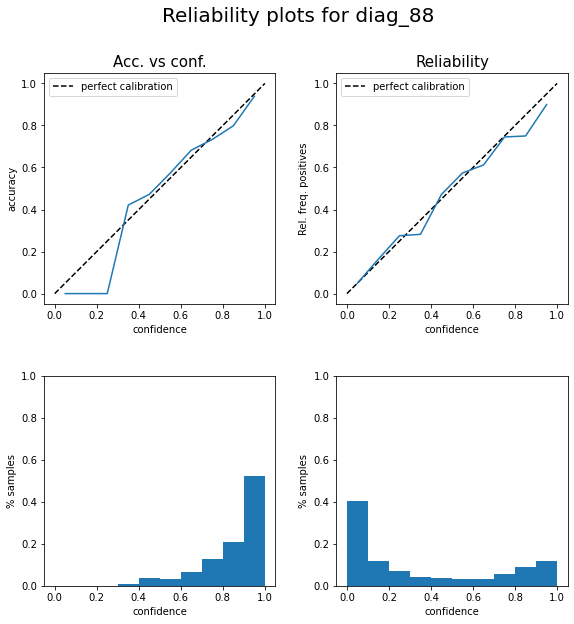

In [224]:
diag = 'diag_88'
data = reliability.loc[idx[diag,:],:].reset_index().to_dict(orient='list')
plot_reliabilityV2(data,accuracy=True,reliability=True,show_percent=True);

In [177]:
reliability.loc[idx[diag,:],:].reset_index().to_dict(orient='list')

{'diag': ['diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88',
  'diag_88'],
 'bin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'ece': [0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228,
  0.0302514239585228],
 'accuracies': [0.0,
  0.0,
  0.0,
  0.4210526315789473,
  0.4722222222222222,
  0.5737704918032787,
  0.6825396825396826,
  0.7336065573770492,
  0.7985257985257985,
  0.9388560157790928],
 'rel_freq_positive_examples': [0.049618320610687,
  0.1645021645021645,
  0.2753623188405797,
  0.282051282051282,
  0.4722222222222222,
  0.5737704918032787,
  0.6119402985074627,
  0.7452830188679245,
  0.75,
  0.8991228070175439],
 'n_samples_predicted_class': [0, 0, 0, 19, 72, 61, 126, 244, 407, 1014],
 'perc_samples_predicted_class': [0.0,
  0.0,
  0.0,
  0.0097786927431806,
  0.037056098816263

In [9]:
reliability.loc[idx[diag,:],:].to_dict()

{'ece': {('diag_88', 0): 0.0302514239585228,
  ('diag_88', 1): 0.0302514239585228,
  ('diag_88', 2): 0.0302514239585228,
  ('diag_88', 3): 0.0302514239585228,
  ('diag_88', 4): 0.0302514239585228,
  ('diag_88', 5): 0.0302514239585228,
  ('diag_88', 6): 0.0302514239585228,
  ('diag_88', 7): 0.0302514239585228,
  ('diag_88', 8): 0.0302514239585228,
  ('diag_88', 9): 0.0302514239585228},
 'accuracies': {('diag_88', 0): 0.0,
  ('diag_88', 1): 0.0,
  ('diag_88', 2): 0.0,
  ('diag_88', 3): 0.4210526315789473,
  ('diag_88', 4): 0.4722222222222222,
  ('diag_88', 5): 0.5737704918032787,
  ('diag_88', 6): 0.6825396825396826,
  ('diag_88', 7): 0.7336065573770492,
  ('diag_88', 8): 0.7985257985257985,
  ('diag_88', 9): 0.9388560157790928},
 'rel_freq_positive_examples': {('diag_88', 0): 0.049618320610687,
  ('diag_88', 1): 0.1645021645021645,
  ('diag_88', 2): 0.2753623188405797,
  ('diag_88', 3): 0.282051282051282,
  ('diag_88', 4): 0.4722222222222222,
  ('diag_88', 5): 0.5737704918032787,
  ('di

(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:ylabel='% samples'>,
        <AxesSubplot:xlabel='confidence', ylabel='accuracy'>], dtype=object))

(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:ylabel='% samples'>,
        <AxesSubplot:xlabel='confidence', ylabel='relative frequency of positive examples'>],
       dtype=object))

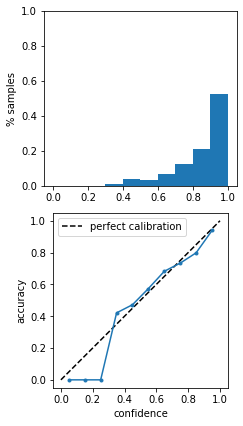

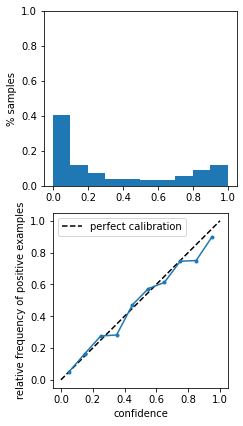

In [5]:
diag = 'diag_88'
accuracies = reliability.loc[idx[diag,:],'accuracies']
perc_samples_acc = reliability.loc[idx[diag,:],'perc_samples_predicted_class']

rel_freq_positive_class = reliability.loc[idx[diag,:],'rel_freq_positive_examples']
perc_samples_rel = reliability.loc[idx[diag,:],'perc_samples_positive_class']

plot_reliability(accuracies,perc_samples=perc_samples_acc)
plot_reliability(rel_freq_positive_class,perc_samples=perc_samples_rel,type_='rel_frequency')

# Improve plotting

In [16]:
import torch.nn.functional as F
import torch

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [30]:
input = torch.rand(1000,39)

In [28]:
input = torch.rand((2,2))
input

F.log_softmax(input,dim=1)
F.log_softmax(input)

tensor([[0.4941, 0.4496],
        [0.2679, 0.9991]])

tensor([[-0.6711, -0.7157],
        [-1.1241, -0.3929]])

/var/folders/__/lcwlgwm95q9_vf5ypxxn3d7c0000gn/T/ipykernel_16246/3565177331.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  F.log_softmax(input)


tensor([[-0.6711, -0.7157],
        [-1.1241, -0.3929]])

In [ ]:
def plot_reliability(y_values, perc_samples=None, type_='accuracy'):
    """
    Creates a reliability plot.
    
    y_values : list
        list of mean accuracy OR relative frequency of positive examples of each bin
    
    """
    
    assert type_ in ['accuracy','rel_frequency']
    
    type_2_name = {'accuracy':'accuracy',
                   'rel_frequency': 'relative frequency of positive examples'
                  }
    
    conf = np.linspace(0,1,len(y_values)+1)[:-1]+0.05
    
    if perc_samples is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3));

        ax.plot([0,1], [0,1], 'k--') ;
        ax.bar(conf, y_values,width=0.1);
        ax.set_xticks((np.arange(0, 1.1, step=0.2)));
        ax.set_ylabel(f'{type_2_name[type_]}');
        ax.set_xlabel(r'confidence');
        ax.set_xticks((np.arange(0, 1.1, step=0.2)));
        ax.set_yticks((np.arange(0, 1.1, step=0.2)));
    
    else:
        fig, ax = plt.subplots(2, 1, figsize=(6, 6),subplot_kw={'aspect': 1});
        
        
        ax[0].bar(conf, perc_samples,width=0.1);
        ax[0].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[0].set_ylabel(r'% samples');
        #ax[0].set_xlabel(r'confidence');
        ax[0].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[0].set_yticks((np.arange(0, 1.1, step=0.2)));
        
        ax[1].plot([0,1], [0,1], 'k--',label='perfect calibration') ;
        ax[1].plot(conf, y_values, marker='.');
        ax[1].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[1].set_ylabel(f'{type_2_name[type_]}');
        ax[1].set_xlabel(r'confidence');
        ax[1].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[1].set_yticks((np.arange(0, 1.1, step=0.2)));
        ax[1].legend();
        
        fig.tight_layout(pad=1.0);

    return fig, ax

# Reliability diagram

In [7]:
diag = 'diag_88'
diagnostic_preds = predictions.loc[:,diag]
diagnostic_logits = df_var_predictions.loc[:,diag]
diagnostic_goldens = df_golden.loc[:,diag]

In [8]:
output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )[['negative_class','positive_class']] # the order is important because of the iloc we do next

preds = diagnostic_preds.to_numpy()
confidences = output_probabilities.apply(lambda row: row.iloc[diagnostic_preds.loc[row.name]], axis=1)
accuracies = preds == diagnostic_goldens.to_numpy()

nbins = 10
bins = np.linspace(0,1,nbins+1)
bins_left = bins[:-1]
bins_right = bins[1:]

acc_in_bin_list = list()
for left,right in zip(bins_left,bins_right):
    in_bin = (confidences > left) & (confidences < right)
    prop_in_bin = in_bin.mean()
    
    if prop_in_bin > 0:
        acc_in_bin_list.append(accuracies[in_bin].mean())
    else:
        acc_in_bin_list.append(0)


In [9]:
def plot_conf(acc, conf):
    """
    acc : list
        list of mean accuracies for each bin
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    ax.plot([0,1], [0,1], 'k--')
    ax.plot(conf, acc, marker='.')
    ax.set_xlabel(r'confidence')
    ax.set_ylabel(r'accuracy')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))

    return fig, ax

(<Figure size 180x162 with 1 Axes>,
 <AxesSubplot:xlabel='confidence', ylabel='accuracy'>)

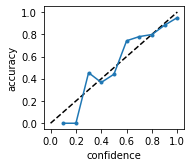

In [11]:
plot_conf(acc_in_bin_list, bins[1:])

In [12]:
diag = 'diag_88'
diagnostic_preds = predictions.loc[:,diag]
diagnostic_logits = df_var_predictions.loc[:,diag]
diagnostic_goldens = df_golden.loc[:,diag]
nbins = 10
uce, entropy_in_bin, errors_in_bin = UCE(diagnostic_preds,diagnostic_logits,diagnostic_goldens,nbins=nbins)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [32]:
errors_in_bin

[0.017391304347826087,
 0.025,
 0.04145077720207254,
 0.0962566844919786,
 0.08994708994708994,
 0.10576923076923077,
 0.19402985074626866,
 0.2191780821917808,
 0.3481953290870488]

In [89]:
def ECE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 11):
    """
    Computes the Expected Uncertainty Calibration error for a batch of predictions of a single diagnosis.
    """
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(diagnostic_logits,bins,right=True)
    
    acc_list = list()
    
    for b in range(1,nbins):
        mask = np.where(idxbins==b)[0]
        if len(mask) == 0:
            print(f'oops no examples in this bin: {b}')
        
        acc = diagnostic_goldens.iloc[mask].mean()
        acc_list.append(acc)
    return {'acc_list':acc_list,'nbins':nbins,'idxbins':idxbins}



diag = 'diag_88'
diagnostic_preds = predictions.loc[:,diag]
diagnostic_logits = df_var_predictions.loc[:,diag]
diagnostic_goldens = df_golden.loc[:,diag]
nbins = 10

res = ECE(diagnostic_preds,diagnostic_logits,diagnostic_goldens)

acc_list = res['acc_list']
nbins=res['nbins']
        

In [96]:
acc_list

[0.04675716440422323,
 0.1339031339031339,
 0.23699421965317918,
 0.392,
 0.6639344262295082,
 0.6761904761904762,
 0.7925925925925926,
 0.8467741935483871,
 0.908256880733945,
 0.8888888888888888]

<BarContainer object of 10 artists>

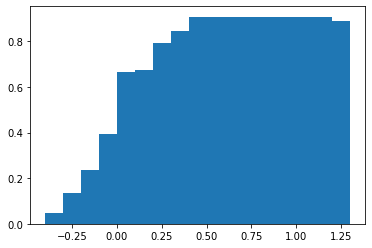

In [94]:
plt.bar(bins[:-1],acc_list)

In [ ]:
def ECE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 10):
    """
    Computes the Expected Uncertainty Calibration error for a batch of predictions of a single diagnosis.
    """
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    
    errors = diagnostic_preds != diagnostic_goldens
    acc
    
    ece = 0
    avg_acc_in_bin_list = []
    #errors_in_bin_list = []
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(entropies,bins,right=True)
    for b in range(1,nbins+1):
        idx = np.where(idxbins==b)[0]
        
        if len(idx) == 0:
            # no uncertainties in this bin
            continue
            
        errors_in_bin = errors.iloc[idx].mean()
        avg_entropy_in_bin = entropies.iloc[idx].mean()
        prop_in_bin = len(idx)/len(idxbins) # Bm / n
        
        uce += np.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin
        
        avg_enropy_in_bin_list.append(avg_entropy_in_bin)
        errors_in_bin_list.append(errors_in_bin)
        
    return uce, avg_enropy_in_bin_list, errors_in_bin_list

In [6]:
def UCE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 10):
    """
    Computes the Expected Uncertainty Calibration error for a batch of predictions of a single diagnosis.
    """
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    # compute entropies
    entropy_calc = lambda row: -1 * sum([e * np.log2(e) for e in row])
    entropies = output_probabilities.apply(entropy_calc,axis=1)
    
    
    errors = diagnostic_preds != diagnostic_goldens
    
    uce = 0
    avg_enropy_in_bin_list = []
    errors_in_bin_list = []
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(entropies,bins,right=True)
    for b in range(1,nbins+1):
        idx = np.where(idxbins==b)[0]
        
        if len(idx) == 0:
            # no uncertainties in this bin
            continue
            
        errors_in_bin = errors.iloc[idx].mean()
        avg_entropy_in_bin = entropies.iloc[idx].mean()
        prop_in_bin = len(idx)/len(idxbins) # Bm / n
        
        uce += np.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin
        
        avg_enropy_in_bin_list.append(avg_entropy_in_bin)
        errors_in_bin_list.append(errors_in_bin)
        
    return uce, avg_enropy_in_bin_list, errors_in_bin_list

how do i test this?

- look at one diagnosis only.
- 
